In [1]:
# Import statements..
import warnings
import time
warnings.filterwarnings('ignore')

try:
    # If you have tensorflow 2 installed access the old tensorflow 1
    import tensorflow.compat.v1 as tf
    tf.disable_eager_execution()
except:
    # You already have tensorflow 1 installed so no need for the above
    import tensorflow as tf
    
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import math

import pandas as pd
dtype = tf.float64
dtype_convert = tf.to_double

np.random.seed(0)

## Squared Exponential Covariance Kernel

The following tensorflow code evaluates a squared exponential covariance in **vectorised** form (more efficient computation). It is good practice to check your tensorflow code as you write it using simple (but often inefficient) numpy code where we are less likely to introduce errors.

In [2]:
def get_lengthscale_euclid_sq_dist(t_X, t_Z, t_lengthscale):
    t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
    xx = t_inv_lengthscale_squared * tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    zz = t_inv_lengthscale_squared * tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)
    return xx + tf.transpose(zz) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)

def create_squared_exp_kernel(t_X1, t_X2, t_signal_variance, t_lengthscale):
    dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    return t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)

###  Task 1: Implement a function that calculates the squared exponential kernel in numpy using for loops and use it to check that the TensorFlow code operates correctly. (1 mark)


In [3]:
def numpy_squared_exp_kernel(X, signal_variance, lengthscale):
    
    klen = len(X)
    
    K = np.empty([klen,klen])
    
    for i in range(klen):
        for j in range(klen):
            sqdiff = np.linalg.norm(X[i]- X[j])**2
            exp_term = -1/(2*lengthscale**2) * sqdiff
            K[i,j] = signal_variance * np.exp(exp_term)
    # Add code using for loops to generate K(X, X)
    
    return K

# Testing part:
lengthscale = 2.3
signal_variance = 1.4

N = 5
X = np.random.randn(N,1)

tf.reset_default_graph()
with tf.Session() as session:
    t_lengthscale = tf.constant(lengthscale, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_squared_exp_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance=t_signal_variance,
                                    t_lengthscale=t_lengthscale)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_squared_exp_kernel(X=X, 
                                      signal_variance=signal_variance, 
                                      lengthscale=lengthscale)
    
    print('My numpy checking code K = \n', numpy_K)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
TensorFlow K =
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]
My numpy checking code K = 
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]


## GP Regression Model

The following is TensorFlow code that implements a regression GP model with a Gaussian likelihood (as per the lecture notes). Look through to see how the function works and correlate the code with the mathematical expressions for the marginal log likelihood and the predictive posterior code. Note that we optimise the **negative log likelihood** in TensorFlow since the optimiser **minimises** the objective function.

In [4]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_lengthscale,
              initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_lengthscale=t_lengthscale,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')


# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Your code here,only need to change in Taks 5a
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plot_mean = pred_mean
    upper_bound = pred_mean + 2.0 * np.sqrt(pred_var)
    lower_bound = pred_mean - 2.0 * np.sqrt(pred_var)
    # - - - - - - Your code above - - - - - - -
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, pred_mean , 'r-')
    plt.plot(input_values,upper_bound , 'r:')
    plt.plot(input_values,lower_bound , 'r:')
    plt.grid(True)
    plt.show()
    return plot_mean, upper_bound,lower_bound

    
    

###  Task 1a: Run the GP model on the following toy dataset to ensure everything is working. 

Instructions for updating:
Use `tf.cast` instead.
Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 24.265875491851364
  opt iter   200: objective = 6.282378000976767
  opt iter   400: objective = 6.282377976574914
  opt iter   600: objective = 6.2823779765748196
  opt iter   800: objective = 6.282377976574889
  opt iter  1000: objective = 6.28237797657496
  opt iter  1200: objective = 6.2823783411924286
  opt iter  1400: objective = 6.282377976574919
  opt iter  1600: objective = 6.28237797657499
  opt iter  1800: objective = 6.282377976598088
Final iter  1999: objective = 6.282377976574939

After Optimisation:
signal_variance = 0.95869
lengthscale = 0.590214
sigma_noise_squared = 0.0145719



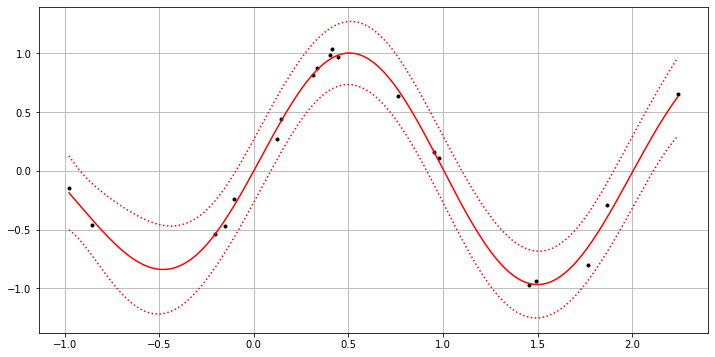

In [5]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = np.random.randn(N,1)
output_data = np.sin(np.pi * input_data) + 0.05 * np.random.randn(N,1)

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



## Bike Traffic Count Dataset

The following data is take from the UK Department of Transport figures counting how many cyclists crossed Vauxhall Bridge over Monday to Friday (week starting 31st July 2008). We note that the counts per hour are integers.

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,31,70,186,351,194,65,23,30,29,22,31,34,59,68,41,23,14,5,4
1,40,64,203,406,201,59,26,32,36,23,31,39,66,73,52,27,15,11,4
2,29,62,194,347,168,58,35,41,31,29,37,39,70,76,30,16,13,12,8
3,35,55,155,318,166,51,43,34,40,21,25,34,52,59,31,21,8,13,5
4,33,44,121,243,139,48,35,44,34,37,27,35,44,52,27,21,16,10,7


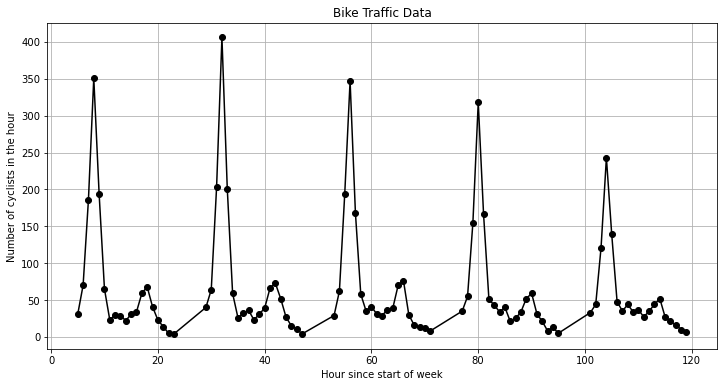

In [6]:
bike_data = pd.read_csv('traffic_data_week_2008_07_31.csv')
bike_data = bike_data.drop([5,6])
counts = bike_data.values.flatten()
times = np.zeros(bike_data.shape)
for n, r in bike_data.iterrows():
    times[n,:] = bike_data.columns.astype(np.float64) + (n*24)
times = times.flatten()

bike_counts = counts[:,np.newaxis]
bike_times = times[:,np.newaxis]

plt.figure(figsize=[12,6])
plt.plot(bike_times, bike_counts, 'ko-')
plt.grid(True)
plt.title('Bike Traffic Data')
plt.xlabel('Hour since start of week')
plt.ylabel('Number of cyclists in the hour')

bike_data

###  Task 2: Run the GP code with a squared exponential kernel on the bike count data. In the box below, comment on the result - how did the Gaussian GP model do? (2 marks)

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 170865.72843773945
  opt iter   200: objective = 1974.7006453601246
  opt iter   400: objective = 1002.7616672497633
  opt iter   600: objective = 769.091789456641
  opt iter   800: objective = 687.350409283504
  opt iter  1000: objective = 653.8017301622657
  opt iter  1200: objective = 638.9149470729812
  opt iter  1400: objective = 632.0909944106791
  opt iter  1600: objective = 628.957637808627
  opt iter  1800: objective = 627.5484481436598
Final iter  1999: objective = 626.9384260486809

After Optimisation:
signal_variance = 162.428
lengthscale = 4.22954
sigma_noise_squared = 6687.03



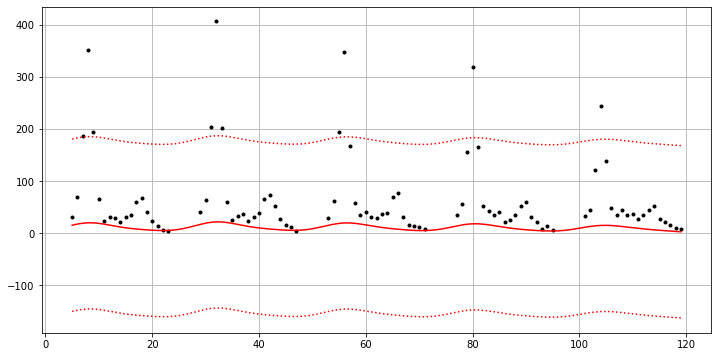

In [7]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))
            
            
            
    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



###  **Type comment in box below:**

The squared exponential kernel failed to capture the pattern within the data and return an accurate prediction. 
The kernel assumes that target values can be predicted by the similarity of adjacent points, with greater weight given to the points closest. However, given the periodic nature of the data, this assumption does not hold and the underlying pattern of the data cannot be learned using these assumptions. The result is a very large predictive variance to capture the fluctuations in the dataset, and a relatively constant mean prediction close to 0 indicating the GP could not learn the function. This also implies that in optimising the marginal log-likelihood, the effect of the bayesian regularisation term was large as the data fit term could not explain the training data, biasing the final predictions to simpler solutions.


## Switch to using periodic kernel

###  Task 3: Implement the periodic kernel (2 marks) and copy and paste the GP code from above, modifying it to use your new periodic kernel and verify the results by running the code with pre-defined settings (2 marks, you will have to add a new positive parameter to represent the period $T$). (4 marks in total)

**The periodic kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left( - 2 \gamma \left[\sin\left(\frac{\pi}{T} \sqrt{\|x_i - x_j\|^2} \right)\right]^2 \right)
$$

**Hyperparameters:**
- Signal variance $\sigma_{\mathrm{f}}^2$ (positive)
- Inverse Lengthscale $\gamma = 1 / \ell^2$ (positive)
- Period $T$ (positive)

In [8]:
def euclid_sq_dist(t_X, t_Z):
    #returns the squared euclidian distance
    xx = tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    zz = tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)
    return xx + tf.transpose(zz) - 2.0 * tf.matmul(t_X, t_Z, transpose_b=True)

def create_periodic_kernel(t_X1, t_X2, t_signal_variance, t_gamma, t_period):
    dist_x1x2_sq = euclid_sq_dist(t_X1,t_X2)
    t_period_term = tf.math.sqrt(dist_x1x2_sq) * np.pi / t_period
    t_gamma_term = -2 * t_gamma * tf.square(tf.math.sin(t_period_term))
    return t_signal_variance * tf.exp(t_gamma_term)

In [9]:
# Testing part:
gamma = 0.5
signal_variance = 1.4
period = 4

N = 5
X = np.random.randn(N,1)

print('testing periodic kernel\n')

def numpy_periodic(x,signal_variance, gamma, period):
    norm = np.empty([len(x),len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
             norm[i,j] = np.linalg.norm(X[i]- X[j])
    period_term = np.pi / period * norm
    gamma_term = -2 * gamma * np.square(np.sin(period_term))
    return signal_variance * np.exp(gamma_term)

tf.reset_default_graph()
with tf.Session() as session:
    t_gamma = tf.constant(gamma, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    t_period = tf.constant(period,dtype=dtype)
    
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_periodic_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance = t_signal_variance,
                                    t_gamma=t_gamma,
                                    t_period=t_period)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_periodic(X,signal_variance, gamma, period)
    
    print('My numpy checking code K = \n', numpy_K)

testing periodic kernel

TensorFlow K =
 [[1.4        0.64789986 1.00191003 1.22464444 1.39079873]
 [0.64789986 1.4        1.1546598  0.52311039 0.60742819]
 [1.00191003 1.1546598  1.4        0.69513163 0.9262136 ]
 [1.22464444 0.52311039 0.69513163 1.4        1.28779576]
 [1.39079873 0.60742819 0.9262136  1.28779576 1.4       ]]
My numpy checking code K = 
 [[1.4        0.64789986 1.00191003 1.22464444 1.39079873]
 [0.64789986 1.4        1.1546598  0.52311039 0.60742819]
 [1.00191003 1.1546598  1.4        0.69513163 0.9262136 ]
 [1.22464444 0.52311039 0.69513163 1.4        1.28779576]
 [1.39079873 0.60742819 0.9262136  1.28779576 1.4       ]]


In [10]:


# Modify this function as appropriate..
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_gamma = create_positive_variable(initial_gamma)
    t_period = create_positive_variable(initial_period)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           'period': t_period,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_signal_variance=t_signal_variance,
                                  t_gamma=t_gamma,
                                  t_period=t_period)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_gamma)) \
                    + 0.5 * tf.square(tf.log(t_period))

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)
    
    ###- - - - - - Your code above - - - - - - -
    gp = GP(description='Periodic Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp



### Task 3a *Run the code below after writing the functions above. (do not change the code below)*.*

Before Optimisation:
signal_variance = 1.0
gamma = 1.0
period = 24.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 136410.78567727085
  opt iter   200: objective = 1257.7561801080453
  opt iter   400: objective = 862.4104264373323
  opt iter   600: objective = 702.4820208741673
  opt iter   800: objective = 621.8596067279037
  opt iter  1000: objective = 577.181701305297
  opt iter  1200: objective = 550.8881167804766
  opt iter  1400: objective = 534.7834972817186
  opt iter  1600: objective = 524.6639594581056
  opt iter  1800: objective = 518.2110616509963
Final iter  1999: objective = 514.0875809355217

After Optimisation:
signal_variance = 3367.55
gamma = 13.7982
period = 24.0078
sigma_noise_squared = 166.431



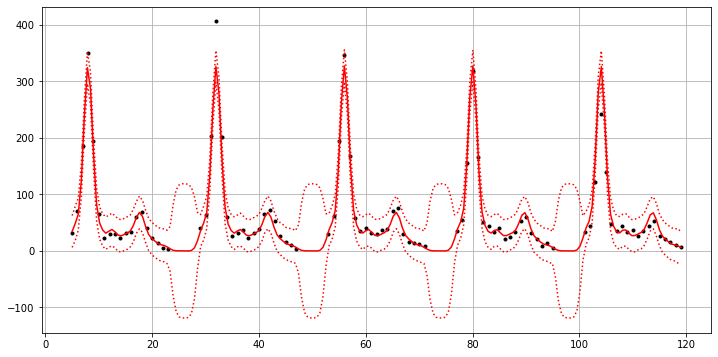

In [11]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_periodic_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    periodic_mean, periodic_upper, periodic_lower= plot_gp_predictions(gp, session, input_values)

## Gaussian Process Regression with Poisson Likelihood

The Poisson distribution is a probability distribution over counts within a fixed time period (positive integer values). The likelihood function is defined in terms of a positive rate parameter $\lambda > 0$ as

$$
p(y) = \frac{\lambda^{y} \exp(-\lambda)}{y!}, \; y \in [0,1,2,3,\dots]
$$

In a similar manner to the GP for binary classification (Bernoulli likelihood), we can define a GP with a Poisson likelihood

$$
p(Y, f \mid X, \theta) = p(Y \mid f) \, p(f \mid X, \theta)
$$

where the $\lambda$ parameter in the Poisson likelihood is a function of $f$. Assuming iid data we have

$$
p(Y \mid X) = \prod_{n=1}^{N} \frac{{\lambda(f_n)}^{y_n} \exp(-\lambda(f_n))}{y_n!}
$$

We put a GP prior over $f$

$$
p(f \mid X, \theta) = \mathcal{N}(f \mid 0, \kappa(X,X;\theta))
$$

however this makes the value of $f$ a real number. We map this to a positive number through the exponential function such that

$$
\lambda(f_n) = \exp(f_n) \; \Rightarrow \; \lambda(f_n) \in \mathcal{R}^{+} 
$$

To calculate the marginal log likelihood we must integrate out the function parameters $f$ such that

$$
\log p(Y \mid X, \theta) = \log \int p(Y \mid f) \, p(f \mid X, \theta) \mathrm{d}f
$$

As for the classification GP, we cannot perform this operation in closed form so we use an variational approximation 

$$
q(f) = \prod_n \mathcal{N}(f_n \mid \mu_n, \sigma^2)
$$

with a mean parameter $\mu_n$ for each $f_n$ and a shared variance $\sigma^2$.

The variational lower bound can then be defined as 

$$
\mathcal{L} =  \sum_n \mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] - \mathrm{KL}\big[ q(f) \,\|\, p(f\mid X, \theta) \big]
$$

We now look at the two terms in the lower bound and the next task is to derive expressions related to the expectation and the KL divergence.


### Task 4a Find an expression for the KL divergence between two **univariate** Gaussian distributions (2 marks) :
    
$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \sigma_0^2) \| \mathcal{N}(x \mid \mu_1, \sigma_1^2) \right] =
\int \mathcal{N}(x \mid \mu_0, \sigma_0^2) \log \frac{\mathcal{N}(x \mid \mu_0, \sigma_0^2)}{\mathcal{N}(x \mid \mu_1, \sigma_1^2)} \mathrm{d}x
$$

Hint: 
The integral of a standardised Gaussian distribution:
$$
 \int \mathcal{N}(x \mid \mu, \sigma^2)\mathrm{d}x  = 1
$$
But the integral in the following form needs to be derived using your basic calculus knowledge
$$
\int x \mathcal{N}(x \mid \mu, \sigma^2)  \mathrm{d}x
$$

The expression after derivation should only contain known parameters such as $\mu_0$, $\mu_1$, $\sigma_0$, $\sigma_1$.




####  **Enter the derivation procedure in this Markdown box..** 

\begin{align}
\log \mathcal{N}(x \mid \mu, \sigma^2) &= -\log(\sigma) - \frac{1}{2}\log(2\pi) - \frac{(x-\mu)^2}{2\sigma^2}\\
\log \frac{\mathcal{N}(x \mid \mu_0, \sigma_0^2)}{\mathcal{N}(x \mid \mu_1, \sigma_1^2)} = \log \mathcal{N}(x \mid \mu_0, \sigma_0^2) - \log \mathcal{N}(x \mid \mu_1, \sigma_1^2) &= \log\frac{\sigma_1}{\sigma_0} - \frac{(x-\mu_0)^2}{2\sigma_0^2} + \frac{(x-\mu_1)^2}{2\sigma_1^2} \\
\mathrm{KL}\left[\mathcal{N_0}\| \mathcal{N_1}\right] &= \log\frac{\sigma_1}{\sigma_0}\int\mathcal{N_0}\mathrm{d}x \ \ ... \tag{1} \\ &- \frac{1}{2\sigma_0^2} \int(x-\mu_0)^2\mathcal{N_0}\mathrm{d}x \ \ ... \tag{2} \\ &+ \frac{1}{2\sigma_1^2} \int(x-\mu_1)^2\mathcal{N_0}\mathrm{d}x \tag{3}
\end{align}

For (1):
\begin{align}
\log\frac{\sigma_1}{\sigma_0}\int\mathcal{N_0}\mathrm{d}x &= \log\frac{\sigma_1}{\sigma_0}
\end{align}

For (2):
\begin{align}
-\frac{1}{2\sigma_0^2} \int(x-\mu_0)^2\mathcal{N_0}\mathrm{d}x = \frac{1}{2\sigma_0^2} \sigma_0^2 = -\frac{1}{2}
\end{align}

For (3):
\begin{align}
(x-\mu_1)^2 = (x-\mu_0 + \mu_0 - \mu_1)^2 &= (x-\mu_0)^2 + (\mu_0 - \mu_1)^2 + 2(\mu_0 - \mu_1)(x-\mu_0) \\
\frac{1}{2\sigma_1^2} \int(x-\mu_1)^2\mathcal{N_0}\mathrm{d}x &= \frac{1}{2\sigma_1^2} \left[ \int(x-\mu_0)^2\mathcal{N_0}\mathrm{d}x + (\mu_0 - \mu_1)^2\int\mathcal{N_0}\mathrm{d}x + 2(\mu_0 - \mu_1) \int(x-\mu_0)\mathcal{N_0}\mathrm{d}x\right] \ \ ... \\
&=  \frac{1}{2\sigma_1^2} \left[ \sigma_0^2 + (\mu_0 - \mu_1)^2 + 0\right]
\end{align}

Summing all parts together:
\begin{align}
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \sigma_0^2) \| \mathcal{N}(x \mid \mu_1, \sigma_1^2) \right] &= \log\frac{\sigma_1}{\sigma_0} -\frac{1}{2} + \frac{\sigma_0^2 + (\mu_0 - \mu_1)^2}{2\sigma_1^2}
\end{align}


The corresponding KL divergence for **multivariate** Gaussians is given by

$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \Sigma_0) \| \mathcal{N}(x \mid \mu_1, \Sigma_1) \right] = 
\frac{1}{2} \left( \mathrm{Tr}[\Sigma_1^{-1} \Sigma_0] + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - N + \log \frac{\det \Sigma_1}{\det \Sigma_0} \right), \;\text{for}\; x \in \mathbb{R}^{N}
$$

### Task 4b  Prove the following expression is the KL divergence between the approximating distrbution and our Gaussian process prior on $f$ (2 marks)

$$
\mathrm{KL}\left[ q(f) \| p(f\mid X, \theta) \right] = \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right), \; K = \kappa(X,X;\theta)
$$




####  **Enter the derivation procedure in this Markdown box..** 

\begin{align}
p(f | X,\theta) = \mathcal{N}(f \mid 0, K) \\ 
q(f) = \mathcal{N}(f|\mu,\sigma^2I)
\end{align}

Substituting $x=f, \mu_0 = \mu, \Sigma_0 = \sigma^2I, \mu_1 = 0, \Sigma_1 = K$ into the above:

\begin{align}
\mathrm{KL}\left[ q(f) \| p(f\mid X, \theta) \right] &= \frac{1}{2} \left( \mathrm{Tr}[K^{-1}\sigma^2 I] + (0-\mu^T)K^{-1}(0-\mu) - N + \log{\frac{\det K}{\det \sigma^2I}} \right) \\
&= \frac{1}{2} \left( \mathrm{Tr}[K^{-1}\sigma^2 I] + \mu^TK^{-1}\mu - N + \log \det K- \log{\det \sigma^2I} \right) \\
&= \frac{1}{2} \left( \mathrm{Tr}[K^{-1}\sigma^2 I] + \mathrm{Tr}[K^{-1}\mu\mu^T] - N + \log \det K- \log {\sigma^2}^N \right) \\
&= \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu\mu^T)] - N + \log \det K - N\log {\sigma^2} \right) \\
\end{align}

####



The expectation expression can be decomposed into a sum over each $f_n \sim \mathcal{N}(\mu_n, \sigma^2)$. 

### Task 4c (Bonus task) Prove that the following expression is the expectation of the log likelihood of the Poisson distribution wrt $q(f_n)$ (2 marks)

$$
\mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] = y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma^2}{2} \right) - \log(y_n!)
$$

Note: for the lower bound we can ignore the $\log(y_n!)$ term since it is constant wrt the hyperparameters and variational parameters.





####  **Enter the derivation procedure in this Markdown box..** 

\begin{align}
p(y_n | f_n) &= \frac{\lambda(f_n)^{y_n} e^{-\lambda(f_n)}}{y_n!} \\
\log(p(y_n | f_n)) &= y_n\log\lambda(f_n) -\lambda(f_n) - \log(y_n!) \\
\log(p(y_n | f_n)) &= y_n(f_n)-\exp(f_n) - \log(y_n!) \\
\text{where} f_n &\sim \mathcal{N}(\mu_n, \sigma^2) \\
\mathbb{E}_{q(f_n)}[y_nf_n] &= y_n\mu_n \\
\mathbb{E}_{q(f_n)}[\exp(f_n)] &= \exp\left( \frac{2\mu_n + \sigma^2}{2} \right) \text{  as exp(f) is log-normally distributed} \\
\mathbb{E}_{q(f_n)}[\log(y_n!)] &= \log(y_n!) \\
\mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] &= y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma^2}{2} \right) - \log(y_n!)
\end{align}

####


## The Lower Bound for the Poisson GP

The final lower bound for the Poisson GP is therefore given by

$$
\mathcal{L} =  \sum_n \left\{ y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma_n^2}{2} \right) - \log(y_n!) \right\} 
- \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right)
$$

### Task 5a: Update the GP code from above to optimise the negative lower bound of the Poisson GP (2 marks)

You will have to introduce extra TensorFlow variables for the variational parameters $\{\mu_n\}$ and $\sigma^2$. You can **initialise** the means as $\mu_n = \log(y_n)$ and the variance $\sigma^2 = 1$ (remember they are variables and not constants).

**IMPORTANT: You will also need to update the predictive posterior using the approach described in the lecture. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution.**


In [12]:
# Copy and paste GP code from above and modify it to make a Poisson GP.
# Run the Poisson GP with a periodic kernel and comment on the output.


# Modify this function as appropriate..
def create_periodic_poisson_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_gamma = create_positive_variable(initial_gamma)
    t_period = create_positive_variable(initial_period)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    # variables for the approximating distribution
    t_q_mean = create_real_variable(tf.log(t_Y))
    t_q_variance = create_positive_variable(1)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           'period': t_period,
                           'sigma_noise_squared': t_sigma_noise_sq,
                           't_q_variance':t_q_variance}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_signal_variance=t_signal_variance,
                                  t_gamma=t_gamma,
                                  t_period=t_period)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))
    
    # Lower Bound
    t_B = t_q_variance * tf.eye(t_N,dtype=dtype) + tf.linalg.matmul(t_q_mean,t_q_mean,transpose_b=True)
    t_A = tf.cholesky_solve(t_L_xx,t_B)
    t_trace = tf.linalg.trace(t_A)
    t_B_lb = (t_trace - dtype_convert(t_D) + t_log_det - dtype_convert(t_D) * tf.log(t_q_variance)) * 0.5
    
    t_sum_terms = t_Y * t_q_mean - tf.exp((2*t_q_mean + t_q_variance)/2)
    t_A_lb = tf.reduce_sum(t_sum_terms)
    
    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_gamma)) \
                    + 0.5 * tf.square(tf.log(t_period))
    
    t_neg_lower_bound = -(t_A_lb - t_B_lb) #+ t_noise_prior + t_hyper_prior
    
    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_q_mean)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        ### Variance calcs:
        
        t_K_x_x = kernel_creation_function(t_X1=tf_input, t_X2=tf_input)
        
        t_Sigma = t_q_variance * tf.eye(t_N,dtype=dtype)
        t_K_inv = tf.linalg.inv(t_K_xx)
        t_Z = tf.matmul(t_K_x_X,t_K_inv)
        
        t_y_var_A = tf.matmul(tf.matmul(t_Z,t_Sigma),t_Z,transpose_b=True)
        t_y_var_B = tf.matmul(t_Z,t_K_x_X,transpose_b=True)
        
        t_y_var = t_y_var_A + t_K_x_x - t_y_var_B

        t_y_var = tf.diag_part(t_y_var) + t_sigma_noise_sq
        
        # Get the predicitve variance
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)
    
    ###- - - - - - Your code above - - - - - - -
    gp = GP(description='Periodic Gaussian Process',
            t_objective=t_neg_lower_bound,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

def plot_gp_predictions(gp, session, input_values):
    # Your code here
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plot_mean = np.exp(pred_mean)
    upper_bound = np.exp(pred_mean + 2.0 * np.sqrt(pred_var))
    lower_bound = np.exp(pred_mean - 2.0 * np.sqrt(pred_var))
    # - - - - - - Your code above - - - - - - -
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, plot_mean , 'r-')
    plt.plot(input_values,upper_bound , 'r:')
    plt.plot(input_values,lower_bound , 'r:')
    plt.grid(True)
    plt.show()
    return plot_mean, upper_bound,lower_bound


### Task 5a *Run the code below after writing the functions above. (do not change the code below)*

Before Optimisation:
signal_variance = 1.0
gamma = 1.0
period = 24.0
sigma_noise_squared = 1.0
t_q_variance = 1.0

  opt iter     0: objective = -18614.565653605954
  opt iter   200: objective = -22731.954044480688
  opt iter   400: objective = -22743.086708280167
  opt iter   600: objective = -22762.536967620366
  opt iter   800: objective = -22771.3341425461
  opt iter  1000: objective = -22781.912801563107
  opt iter  1200: objective = -22710.64582509375
  opt iter  1400: objective = -22788.940743713392
  opt iter  1600: objective = -22804.113527844962
  opt iter  1800: objective = -22780.36519938234
Final iter  1999: objective = -22797.1739302389

After Optimisation:
signal_variance = 8.28562
gamma = 1.9622
period = 24.0123
sigma_noise_squared = 0.01635
t_q_variance = 0.00025874



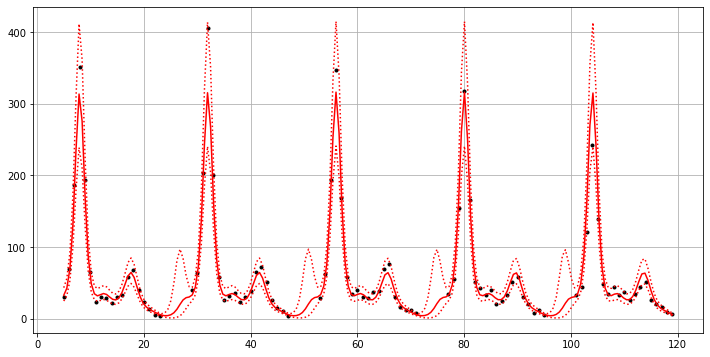

In [13]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

pgp = create_periodic_poisson_gp(input_data   = input_data, 
                        output_data  = output_data, 
                        initial_signal_variance = 1.0,
                        initial_gamma  = 1.0,
                        initial_period = 24.0,
                        initial_sigma_noise_sq = 1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = pgp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(pgp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(pgp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    LB_mean, LB_upper, LB_lower = plot_gp_predictions(pgp, session, input_values)

### Task 5b: Write comments in the Markdown box below.. (2 marks)

The output for the Poisson GP using a periodic kernel shows several improvements over the output from task 3:
- The confidence bounds are tighter outside the morning peak times, while still capturing all observed data points
- The confidence bound for the morning peak is larger, which also captures the high traffic observed on the second day
- The confidence interval does not fall below 0 as in the previous case
- The confidence interval is tighter where we have no observed data, which matches the assumption the real assumption that it would be unlikely to observe a peak in traffic in the early morning hours